In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor


Ruoqing Gao: Data preprocessing, 1-D CNN;  
Mengqing Fan: LSTM;  
Luxin Xu: RNN, XGBoost;  
Jingjie Ouyang: GRU

# Load dataset

In [2]:
#pip install tensorflow
#!pip install scikeras
# !pip install xgboost

In [3]:
all_df = pd.read_csv("Ali_Baba_Stock_Data.csv")
all_df
print(all_df.dtypes)

Date          object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object


# Data Preprocess

## Dataset Split

In [4]:
all_df['Date'] = pd.to_datetime(all_df['Date'])
print(all_df.dtypes)

Date         datetime64[ns]
Adj Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume                int64
dtype: object


In [5]:
print("\n duplicate date:",all_df.duplicated('Date').sum())


 duplicate date: 0


In [6]:
all_df = all_df.sort_values('Date')

In [7]:
all_df['Year'] = all_df['Date'].dt.year
all_df['Month'] = all_df['Date'].dt.month
all_df['Weekday'] = all_df['Date'].dt.weekday
# cyclical_encode
all_df['Month_Sin'] = np.sin(2 * np.pi * (all_df['Month'] - 1) / 12)
all_df['Month_Cos'] = np.cos(2 * np.pi * (all_df['Month'] - 1) / 12)
all_df['Weekday_Sin'] = np.sin(2 * np.pi * all_df['Weekday'] / 7)
all_df['Weekday_Cos'] = np.cos(2 * np.pi * all_df['Weekday'] / 7)

In [8]:
def time_based_split(df, train_ratio=0.9, test_ratio=0.1):
    n = len(df)
    train_end = int(n * train_ratio)
    test_end = train_end + int(n * test_ratio)
    train = df.iloc[:train_end].copy()
    test = df.iloc[train_end:].copy()

    return train, test

df_train, df_test = time_based_split(all_df, train_ratio=0.9, test_ratio=0.1)
assert df_train['Date'].max() < df_test['Date'].min(), "The test set contains the data after the train set!"

In [9]:
print(f"training date from {df_train['Date'].min().strftime('%Y-%m-%d')} to {df_train['Date'].max().strftime('%Y-%m-%d')}")

training date from 2014-09-19 to 2024-01-29


In [10]:
print(f"test date from {df_test['Date'].min().strftime('%Y-%m-%d')} to {df_test['Date'].max().strftime('%Y-%m-%d')}")

test date from 2024-01-30 to 2025-02-13


## Data Cleaning

In [11]:
missing_counts = df_train.isnull().sum()
print(f"Count of missing values: {missing_counts}")

Count of missing values: Date           0
Adj Close      0
Close          0
High           0
Low            0
Open           0
Volume         0
Year           0
Month          0
Weekday        0
Month_Sin      0
Month_Cos      0
Weekday_Sin    0
Weekday_Cos    0
dtype: int64


## Feature Engineering

In [12]:
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def stochastic_oscillator(df, k_window=14, d_window=3):
    high_roll = df['High'].rolling(window=k_window).max()
    low_roll = df['Low'].rolling(window=k_window).min()
    stoch_k = ((df['Close'] - low_roll)/(high_roll - low_roll)) * 100
    stoch_d = stoch_k.rolling(window=d_window).mean()
    return stoch_k, stoch_d

def macd_features(df, short_window=12, long_window=26, signal_window=9):
    ema_short = df['Close'].ewm(span=short_window, adjust=False).mean()
    ema_long = df['Close'].ewm(span=long_window, adjust=False).mean()
    macd = ema_short - ema_long
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    macd_hist = macd - signal
    return macd, signal, macd_hist

def bollinger_bands(df, window=20, k=2):
    sma = df['Close'].rolling(window=window).mean()
    std = df['Close'].rolling(window=window).std()
    upper = sma + k * std
    lower = sma - k * std
    return upper, sma, lower

In [13]:
df_train['RSI'] = calculate_rsi(df_train)
df_train['Stochastic_K'], df_train['Stochastic_D'] = stochastic_oscillator(df_train)
df_train['MACD'], df_train['MACD_Signal'], df_train['MACD_Hist'] = macd_features(df_train)
df_train['Bollinger_Upper'], df_train['Bollinger_Middle'], df_train['Bollinger_Lower'] = bollinger_bands(df_train)

In [14]:
df_train

,Date,Adj Close,Close,High,Low,Open,Volume,Year,Month,Weekday,...,Weekday_Cos,RSI,Stochastic_K,Stochastic_D,MACD,MACD_Signal,MACD_Hist,Bollinger_Upper,Bollinger_Middle,Bollinger_Lower
0,2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400,2014,9,4,...,-0.900969,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800,2014,9,0,...,1.000000,NaN,NaN,NaN,-0.319088,-0.063818,-0.255271,NaN,NaN,NaN
2,2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800,2014,9,1,...,0.623490,NaN,NaN,NaN,-0.782430,-0.207540,-0.574890,NaN,NaN,NaN
3,2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000,2014,9,2,...,-0.222521,NaN,NaN,NaN,-0.865305,-0.339093,-0.526212,NaN,NaN,NaN
4,2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000,2014,9,3,...,-0.900969,NaN,NaN,NaN,-1.051999,-0.481674,-0.570325,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,2024-01-23,72.445503,74.019997,74.500000,72.550003,72.754997,53017700,2024,1,1,...,0.623490,48.136942,73.459201,38.890558,-1.459128,-1.432264,-0.026864,79.017176,73.002499,66.987823
2351,2024-01-24,73.600403,75.199997,75.620003,74.220001,75.285004,36503300,2024,1,2,...,-0.222521,46.382090,94.227582,62.522496,-1.040492,-1.353910,0.313418,79.006901,72.998499,66.990097
2352,2024-01-25,72.279121,73.849998,75.500000,73.559998,75.190002,23268600,2024,1,3,...,-0.900969,47.826071,80.311422,82.666068,-0.808335,-1.244795,0.436459,78.772138,72.898499,67.024861
2353,2024-01-26,72.435722,74.010002,74.720001,72.919998,73.099998,19418200,2024,1,4,...,-0.900969,52.917156,82.091217,85.543407,-0.604471,-1.116730,0.512259,78.498058,72.793499,67.088941


In [15]:
nan_col = ['Stochastic_K','Bollinger_Lower','Bollinger_Upper','RSI','Bollinger_Middle','Stochastic_D']
df_train = df_train.dropna(subset=nan_col).reset_index(drop=True)

In [16]:
print(df_train.isnull().sum())

Date                0
Adj Close           0
Close               0
High                0
Low                 0
Open                0
Volume              0
Year                0
Month               0
Weekday             0
Month_Sin           0
Month_Cos           0
Weekday_Sin         0
Weekday_Cos         0
RSI                 0
Stochastic_K        0
Stochastic_D        0
MACD                0
MACD_Signal         0
MACD_Hist           0
Bollinger_Upper     0
Bollinger_Middle    0
Bollinger_Lower     0
dtype: int64


In [17]:
df_train

,Date,Adj Close,Close,High,Low,Open,Volume,Year,Month,Weekday,...,Weekday_Cos,RSI,Stochastic_K,Stochastic_D,MACD,MACD_Signal,MACD_Hist,Bollinger_Upper,Bollinger_Middle,Bollinger_Lower
0,2014-10-16,85.806587,88.849998,89.175003,84.014999,84.980003,15232000,2014,10,3,...,-0.900969,45.052243,74.845119,43.437098,-1.548362,-1.594224,0.045862,92.446500,88.161499,83.876498
1,2014-10-17,84.898788,87.910004,90.900002,87.669998,90.400002,17360700,2014,10,4,...,-0.900969,47.290334,63.040836,57.486153,-1.393168,-1.554013,0.160845,91.192598,87.862499,84.532401
2,2014-10-20,85.236794,88.260002,89.500000,87.860001,88.000000,9891400,2014,10,0,...,1.000000,48.126996,67.367143,68.417700,-1.227781,-1.488767,0.260985,90.979348,87.780999,84.582651
3,2014-10-21,87.786369,90.900002,92.500000,88.500000,89.099998,23243800,2014,10,1,...,0.623490,65.345279,83.488152,71.298710,-0.873615,-1.365736,0.492122,91.439159,87.967500,84.495840
4,2014-10-22,88.491356,91.629997,93.500000,91.010002,92.250000,20364500,2014,10,2,...,-0.222521,64.828037,82.506994,77.787430,-0.527945,-1.198178,0.670233,91.686379,88.020499,84.354620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,2024-01-23,72.445503,74.019997,74.500000,72.550003,72.754997,53017700,2024,1,1,...,0.623490,48.136942,73.459201,38.890558,-1.459128,-1.432264,-0.026864,79.017176,73.002499,66.987823
2332,2024-01-24,73.600403,75.199997,75.620003,74.220001,75.285004,36503300,2024,1,2,...,-0.222521,46.382090,94.227582,62.522496,-1.040492,-1.353910,0.313418,79.006901,72.998499,66.990097
2333,2024-01-25,72.279121,73.849998,75.500000,73.559998,75.190002,23268600,2024,1,3,...,-0.900969,47.826071,80.311422,82.666068,-0.808335,-1.244795,0.436459,78.772138,72.898499,67.024861
2334,2024-01-26,72.435722,74.010002,74.720001,72.919998,73.099998,19418200,2024,1,4,...,-0.900969,52.917156,82.091217,85.543407,-0.604471,-1.116730,0.512259,78.498058,72.793499,67.088941


## Feature importance calculated by Random Forests

In [18]:
X_rank_features = df_train.drop(['Close', 'Adj Close', 'Date', 'Year', 'Weekday', 'Month'] , axis=1)
y = df_train['Close']

model = RandomForestRegressor(random_state = 42)
model.fit(X_rank_features, y)
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_rank_features.columns,
    'Importance': feature_importances 
}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,High,0.721734
1,Low,0.277621
2,Open,0.000335
9,Stochastic_K,0.000058
3,Volume,0.000035
12,MACD_Signal,0.000029
13,MACD_Hist,0.000024
16,Bollinger_Lower,0.000024
14,Bollinger_Upper,0.000020
11,MACD,0.000020


In [19]:
selected_features = importance_df['Feature']
X_train = df_train[selected_features]
X_train

,High,Low,Open,Stochastic_K,Volume,MACD_Signal,MACD_Hist,Bollinger_Lower,Bollinger_Upper,MACD,RSI,Bollinger_Middle,Weekday_Sin,Stochastic_D,Month_Cos,Weekday_Cos,Month_Sin
0,89.175003,84.014999,84.980003,74.845119,15232000,-1.594224,0.045862,83.876498,92.446500,-1.548362,45.052243,88.161499,0.433884,43.437098,-1.836970e-16,-0.900969,-1.0
1,90.900002,87.669998,90.400002,63.040836,17360700,-1.554013,0.160845,84.532401,91.192598,-1.393168,47.290334,87.862499,-0.433884,57.486153,-1.836970e-16,-0.900969,-1.0
2,89.500000,87.860001,88.000000,67.367143,9891400,-1.488767,0.260985,84.582651,90.979348,-1.227781,48.126996,87.780999,0.000000,68.417700,-1.836970e-16,1.000000,-1.0
3,92.500000,88.500000,89.099998,83.488152,23243800,-1.365736,0.492122,84.495840,91.439159,-0.873615,65.345279,87.967500,0.781831,71.298710,-1.836970e-16,0.623490,-1.0
4,93.500000,91.010002,92.250000,82.506994,20364500,-1.198178,0.670233,84.354620,91.686379,-0.527945,64.828037,88.020499,0.974928,77.787430,-1.836970e-16,-0.222521,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,74.500000,72.550003,72.754997,73.459201,53017700,-1.432264,-0.026864,66.987823,79.017176,-1.459128,48.136942,73.002499,0.781831,38.890558,1.000000e+00,0.623490,0.0
2332,75.620003,74.220001,75.285004,94.227582,36503300,-1.353910,0.313418,66.990097,79.006901,-1.040492,46.382090,72.998499,0.974928,62.522496,1.000000e+00,-0.222521,0.0
2333,75.500000,73.559998,75.190002,80.311422,23268600,-1.244795,0.436459,67.024861,78.772138,-0.808335,47.826071,72.898499,0.433884,82.666068,1.000000e+00,-0.900969,0.0
2334,74.720001,72.919998,73.099998,82.091217,19418200,-1.116730,0.512259,67.088941,78.498058,-0.604471,52.917156,72.793499,-0.433884,85.543407,1.000000e+00,-0.900969,0.0


## Data normalisation

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'High'),
  Text(1, 0, 'Low'),
  Text(2, 0, 'Open'),
  Text(3, 0, 'Stochastic_K'),
  Text(4, 0, 'Volume'),
  Text(5, 0, 'MACD_Signal'),
  Text(6, 0, 'MACD_Hist'),
  Text(7, 0, 'Bollinger_Lower'),
  Text(8, 0, 'Bollinger_Upper'),
  Text(9, 0, 'MACD'),
  Text(10, 0, 'RSI'),
  Text(11, 0, 'Bollinger_Middle'),
  Text(12, 0, 'Weekday_Sin'),
  Text(13, 0, 'Stochastic_D'),
  Text(14, 0, 'Month_Cos'),
  Text(15, 0, 'Weekday_Cos'),
  Text(16, 0, 'Month_Sin')])

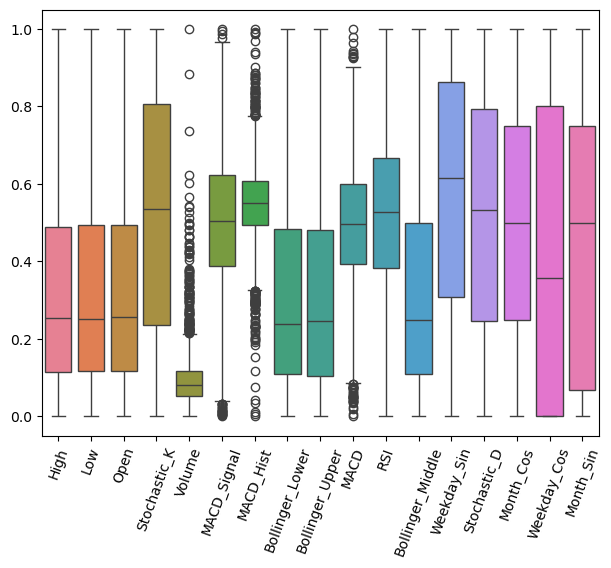

In [20]:
scaler_minmax = MinMaxScaler()
scaler_sta = StandardScaler()

Xs_scaled = pd.DataFrame(scaler_minmax.fit_transform(X_train), columns=X_train.columns)
sns.boxplot(data=Xs_scaled)
plt.tight_layout()
plt.xticks(rotation=70)

# Modelling

__GRU__

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# build GRU Model
def create_gru(window_size=30, units=64, dropout_rate=0.3, learning_rate=0.001, n_features=17):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=False, input_shape=(window_size, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Construct a time series
def create_sequences(X, y, window_size=30):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i - window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# hyperparametric lattice
param_grid_gru = [
    {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0005}
]


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Grid Search Function
def gru_evaluation(X_scaled, y, window_sizes, param_grid):
    best_window_size = None
    best_score = float('inf')
    best_params = None

    for window in window_sizes:
        X_seq, y_seq = create_sequences(X_scaled, y, window)
        tscv = TimeSeriesSplit(n_splits=5)

        for params in param_grid:
            model = create_gru(window_size=window, n_features=X_scaled.shape[1], **params)

            fold_mse_scores = []
            for train_idx, val_idx in tscv.split(X_seq, y_seq):
                X_train, X_val = X_seq[train_idx], X_seq[val_idx]
                y_train, y_val = y_seq[train_idx], y_seq[val_idx]

                model.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=20,
                          batch_size=32,
                          verbose=0,
                          callbacks=[early_stop])

                y_pred = model.predict(X_val)
                mse = mean_squared_error(y_val, y_pred)
                fold_mse_scores.append(mse)

            avg_mse = np.mean(fold_mse_scores)

            if avg_mse < best_score:
                best_score = avg_mse
                best_window_size = window
                best_params = params

    return best_score, best_window_size, best_params

In [23]:
window_sizes = [30, 60, 90]
best_score, best_window_size, best_params = gru_evaluation(Xs_scaled, df_train['Close'], window_sizes, param_grid_gru)

print(f"Best GRU Model - MSE: {best_score:.4f}, Window Size: {best_window_size}, Best Hyperparameters: {best_params}")

X_train_seq, y_train_seq = create_sequences(Xs_scaled, df_train['Close'].values, window_size=best_window_size)
print(f"Training final GRU model with Window Size: {best_window_size}, Parameters: {best_params}")
best_gru_model = create_gru(window_size=best_window_size, n_features=Xs_scaled.shape[1], **best_params)
best_gru_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)


12/12 [==============================] - 0s 9ms/step
Best GRU Model - MSE: 974.3209, Window Size: 30, Best Hyperparameters: {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Training final GRU model with Window Size: 30, Parameters: {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Epoch 1/50
65/65 [==============================] - 3s 21ms/step - loss: 21472.8047 - val_loss: 2141.0676
Epoch 2/50
65/65 [==============================] - 1s 14ms/step - loss: 9802.8438 - val_loss: 489.1694
Epoch 3/50
65/65 [==============================] - 1s 14ms/step - loss: 4143.9658 - val_loss: 3446.9519
Epoch 4/50
65/65 [==============================] - 1s 14ms/step - loss: 3639.6445 - val_loss: 3608.1978
Epoch 5/50
65/65 [==============================] - 1s 15ms/step - loss: 3412.6724 - val_loss: 2372.5076
Epoch 6/50
65/65 [==============================] - 1s 15ms/step - loss: 1575.1633 - val_loss: 37.4413
Epoch 7/50
65/65 [==============================] - 1s 14ms/step - loss

In [24]:
from sklearn.metrics import r2_score

df_test['RSI'] = calculate_rsi(df_test)
df_test['Stochastic_K'], df_test['Stochastic_D'] = stochastic_oscillator(df_test)
df_test['MACD'], df_test['MACD_Signal'], df_test['MACD_Hist'] = macd_features(df_test)
df_test['Bollinger_Upper'], df_test['Bollinger_Middle'], df_test['Bollinger_Lower'] = bollinger_bands(df_test)
df_test = df_test.dropna(subset=nan_col).reset_index(drop=True)


X_test = df_test[X_train.columns]
Xs_test_scaled = pd.DataFrame(scaler_minmax.transform(X_test), columns=X_test.columns)


X_test_seq, y_test_seq = create_sequences(Xs_test_scaled.values, df_test['Close'].values, window_size=best_window_size)


gru_test_pred = best_gru_model.predict(X_test_seq).reshape(-1)


gru_test_mse = mean_squared_error(y_test_seq, gru_test_pred)
gru_test_mae = mean_absolute_error(y_test_seq, gru_test_pred)
gru_test_r2 = r2_score(y_test_seq, gru_test_pred)

print(f"GRU Test - MSE: {gru_test_mse:.4f}, MAE: {gru_test_mae:.4f}, R²: {gru_test_r2:.4f}")

7/7 [==============================] - 0s 6ms/step
GRU Test - MSE: 8.5353, MAE: 2.2152, R²: 0.9295


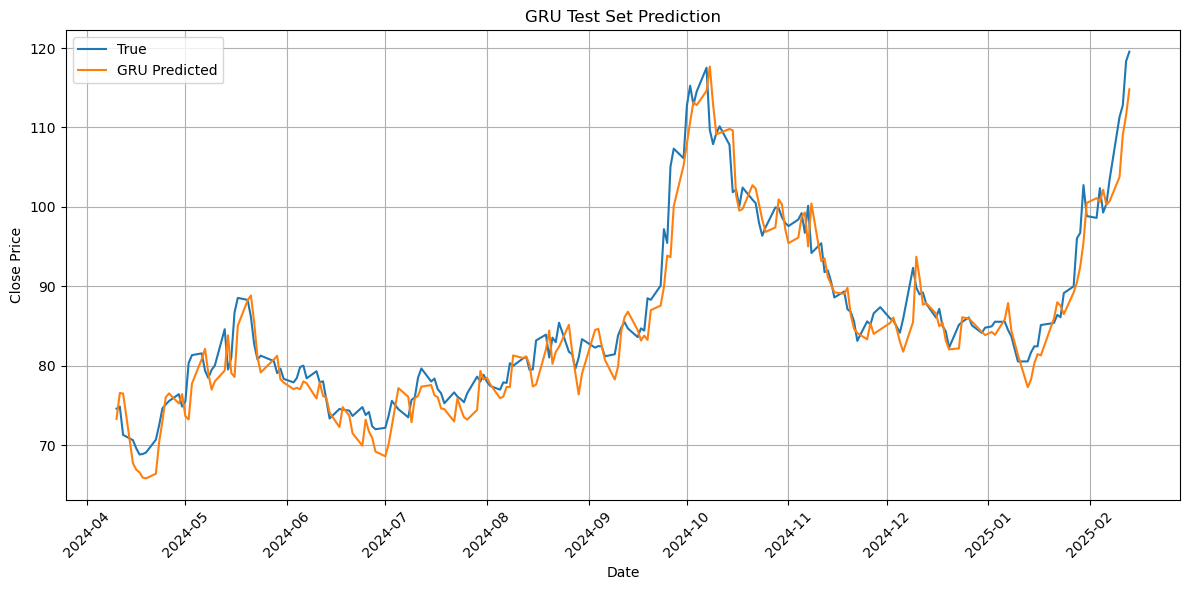

In [25]:
test_dates = df_test['Date'].values[-len(y_test_seq):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_seq, label='True')
plt.plot(test_dates, gru_test_pred, label='GRU Predicted')
plt.title("GRU Test Set Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

__Window Slide__

In [21]:
window_sizes = [5, 14, 30]
def create_dataset(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

__LSTM__

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [27]:
# Define the LSTM model with hyperparameters as input arguments
def create_lstm(window_size=30, dropout_rate=0.2, learning_rate=0.001, n_features=17):
    model = Sequential()
    model.add(Input(shape=(window_size, n_features)))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

window_size = 30
Xs_train, y_train = create_dataset(Xs_scaled, y, window_size)

# Define the hyperparameters manually for tuning
dropout_rate = 0.3
learning_rate = 0.005
batch_size = 32

# Create and train the model with selected hyperparameters
best_model = create_lstm(window_size=30, dropout_rate=dropout_rate, learning_rate=learning_rate, n_features=Xs_train.shape[2])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

df_test['RSI'] = calculate_rsi(df_test)
df_test['Stochastic_K'], df_test['Stochastic_D'] = stochastic_oscillator(df_test)
df_test['MACD'], df_test['MACD_Signal'], df_test['MACD_Hist'] = macd_features(df_test)
df_test['Bollinger_Upper'], df_test['Bollinger_Middle'], df_test['Bollinger_Lower'] = bollinger_bands(df_test)
df_test = df_test.dropna(subset=nan_col).reset_index(drop=True)

true_label = df_test['Close']
# Filter and preprocess test set
# Date range from April 2024 to February 2025

start_date = "2024-04-01"
end_date = "2025-02-28"
df_test_filtered = df_test[(df_test['Date'] >= start_date) & (df_test['Date'] <= end_date)].reset_index(drop=True)

aligned_dates = df_test_filtered['Date'].iloc[window_size:].reset_index(drop=True)
X_test = df_test_filtered[selected_features]
Xs_test_scaled = pd.DataFrame(scaler_minmax.transform(X_test), columns=X_test.columns)
Xs_test, y_test = create_dataset(Xs_test_scaled, true_label.loc[df_test_filtered.index], window_size)

# Train the model
best_model.fit(Xs_train, y_train, epochs=50, batch_size=batch_size, verbose=1, validation_data=(Xs_test, y_test), callbacks=[early_stopping])

# Prediction and evaluation with the best model
y_pred_lstm = best_model.predict(Xs_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM Mean Squared Error: {mse_lstm}, R2 Score: {r2_lstm}")

Epoch 1/50
73/73 [==============================] - 2s 16ms/step - loss: 8766.1357 - val_loss: 2214.4158
Epoch 2/50
73/73 [==============================] - 1s 11ms/step - loss: 3662.4102 - val_loss: 2770.8601
Epoch 3/50
73/73 [==============================] - 1s 12ms/step - loss: 3702.1440 - val_loss: 3030.9724
Epoch 4/50
73/73 [==============================] - 1s 12ms/step - loss: 3640.7966 - val_loss: 1596.0928
Epoch 5/50
73/73 [==============================] - 1s 12ms/step - loss: 1963.6047 - val_loss: 66.4226
Epoch 6/50
73/73 [==============================] - 1s 12ms/step - loss: 248.8678 - val_loss: 32.4121
Epoch 7/50
73/73 [==============================] - 1s 12ms/step - loss: 193.7616 - val_loss: 49.5147
Epoch 8/50
73/73 [==============================] - 1s 12ms/step - loss: 210.8737 - val_loss: 20.4261
Epoch 9/50
73/73 [==============================] - 1s 12ms/step - loss: 197.1471 - val_loss: 19.9914
Epoch 10/50
73/73 [==============================] - 1s 12ms/step - l

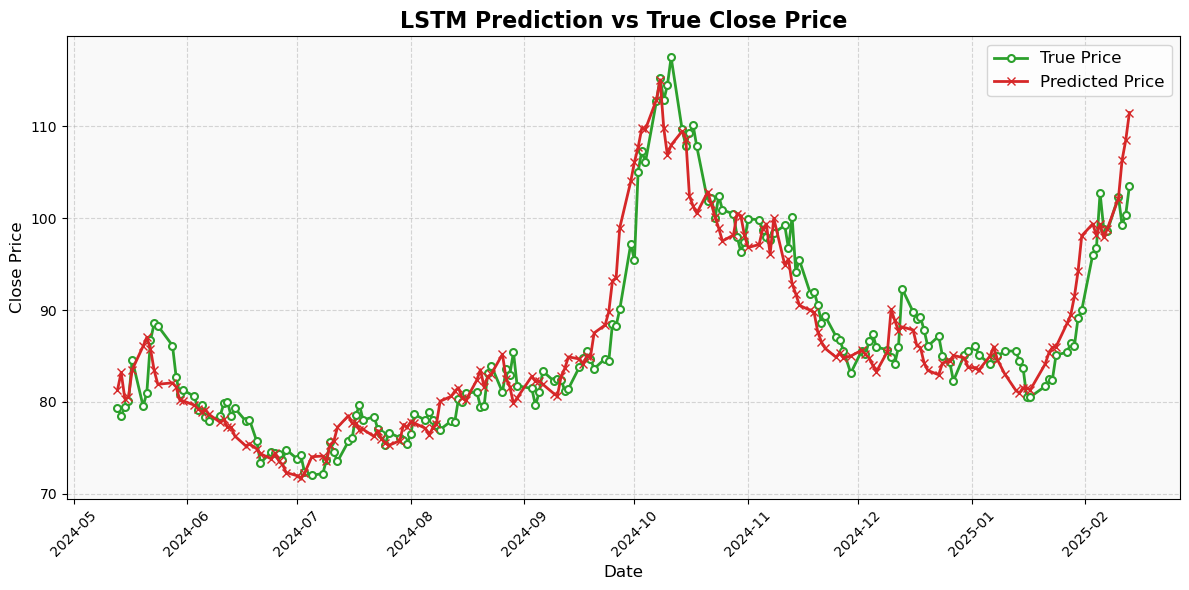

In [28]:
# Visualize results
plt.figure(figsize=(12, 6))

# True values with circles 'o'
plt.plot(aligned_dates, y_test, label="True Price", color="#2ca02c", linewidth=2.0,
         marker='o', markersize=5, markerfacecolor='white', markeredgewidth=1.5)

# Predicted values with crosses 'x'
plt.plot(aligned_dates, y_pred_lstm, label="Predicted Price", color="#d62728", linewidth=2.0,
         marker='x', markersize=6)

plt.title("LSTM Prediction vs True Close Price", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.gca().set_facecolor("#f9f9f9")  
plt.tight_layout()

plt.show()



__1D-CNN__

In [22]:
def create_cnn(window_size=30, filter1=64, kernel_size1=5, 
               dropout_rate=0.3, learning_rate=0.001, n_features=17):
    model = Sequential()
    #input
    model.add(Input(shape=(window_size, n_features)))
    #first convolution layer
    model.add(Conv1D(filters=filter1, kernel_size=kernel_size1, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    #second convolution layer
    # model.add(Conv1D(filters=filter2, kernel_size=kernel_size2, activation='relu', padding='same'))
    # model.add(MaxPooling1D(pool_size=2))
    # model.add(Dropout(dropout_rate))
    #output layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    #Optimisation
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [23]:
param_grid = {
    'model__filter1': [32, 64],
    'model__kernel_size1': [5, 3],    
    # 'model__filter2': [64, 128] ,    
    # 'model__kernel_size2': [3],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0005]
}

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [25]:
def cnn_evaluation(X_scaled, y, window_sizes, param_grid):

    best_window_size = None
    best_score = float('inf')
    best_params = None

    for window in window_sizes:
        Xs_train, y_train = create_dataset(X_scaled, y, window)
        print(f"Window size: {window}, Xs_train shape: {Xs_train.shape}, y_train shape: {y_train.shape}")
        # Xs_train = np.expand_dims(Xs_train, axis = -1) 
    
        cnn_model = KerasRegressor(model=create_cnn, window_size=window, epochs=5, batch_size=32, verbose=1)
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(estimator=cnn_model, 
                                   param_grid=param_grid, 
                                   cv=tscv, 
                                   scoring='neg_mean_squared_error',
                                   n_jobs=1)
        grid_result = grid_search.fit(Xs_train, y_train, callbacks=[early_stop])

        best_score_for_window = grid_search.best_score_
        best_params_for_window = grid_search.best_params_

        if best_score_for_window < best_score:
            best_score = best_score_for_window
            best_window_size = window
            best_params = best_params_for_window

    return best_score, best_window_size, best_params

In [26]:
best_score, best_window_size, best_params = cnn_evaluation(Xs_scaled, y, window_sizes, param_grid)
true_best_params = {key.replace('model__',''): value for key, value in best_params.items()}
print(f"Best score: {best_score}, Best window size: {best_window_size}, Best parameters: {true_best_params}")

Window size: 5, Xs_train shape: (2331, 5, 17), y_train shape: (2331,)
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6858.2031
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6740.2178
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6191.4932
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5021.5439
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3560.0498 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 10950.7900
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8408.4229
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2836.1348
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 558.4775
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 466.8994
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 17618.6426
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11564.2344
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━

In [27]:
df_test['RSI'] = calculate_rsi(df_test)
df_test['Stochastic_K'], df_test['Stochastic_D'] = stochastic_oscillator(df_test)
df_test['MACD'], df_test['MACD_Signal'], df_test['MACD_Hist'] = macd_features(df_test)
df_test['Bollinger_Upper'], df_test['Bollinger_Middle'], df_test['Bollinger_Lower'] = bollinger_bands(df_test)

df_test = df_test.dropna(subset=nan_col).reset_index(drop=True)

true_label = df_test['Close']
aligned_dates = df_test['Date'].iloc[30:].reset_index(drop=True)
X_test = df_test[selected_features]
Xs_test_scaled = pd.DataFrame(scaler_minmax.transform(X_test), columns=X_test.columns)
Xs_test, y_test = create_dataset(Xs_test_scaled, true_label, 30)

In [28]:
Xs_train, y_train = create_dataset(Xs_scaled, y, 30)

In [32]:
# cnn_model_final = create_cnn(window_size = best_window_size, **true_best_params)
cnn_model_final = create_cnn(window_size = 30, dropout_rate=0.2, filter1=64, kernel_size1 = 5, learning_rate=0.001)
cnn_model_final.fit(Xs_train, y_train, epochs = 50, batch_size=32, verbose=1)
y_pred_cnn = cnn_model_final.predict(Xs_test)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
r2_cnn = r2_score(y_test, y_pred_cnn)
print(f"Mean Squared Error: {mse_cnn}, R2 Score: {r2_cnn}")

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 14030.2568
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 292.1314
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 113.0309
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 102.8731
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 95.8402
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 89.7581
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 83.2433
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 82.2424
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 72.6844
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 68.9247
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.8505
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 74.3828
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 61.4050
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 56.4186
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step -

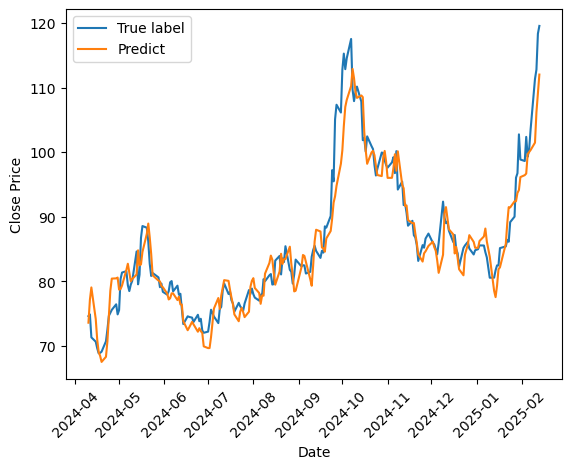

In [33]:
plt.figure()
plt.plot(aligned_dates,y_test, label="True label") 
plt.plot(aligned_dates,y_pred_cnn, label="Predict")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.legend()

__RNN__

In [50]:
from tensorflow.keras.layers import SimpleRNN

#build RNN model
def create_rnn(window_size=14, units=64, dropout_rate=0.3, learning_rate=0.001, n_features=17):
    model = Sequential()
    model.add(Input(shape=(window_size, n_features)))
    model.add(SimpleRNN(units=units, activation='tanh', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [51]:
#parameter grid for hyperparameter tuning
param_grid_rnn = {
    'model__units': [32, 64],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0005]
}

#early stopping to prevant overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [52]:
#evaluate RNN using different window sizes and hyperparameter grid
def rnn_evaluation(X_scaled, y, window_sizes, param_grid):
    best_window_size = None
    best_score = float('inf')
    best_params = None

#loop over different window sizes to find the best time step for RNN
    for window in window_sizes:
        X_seq, y_seq = create_dataset(X_scaled, y, window)

        rnn_model = KerasRegressor(
            model=create_rnn,
            window_size=window,
            n_features=X_scaled.shape[1],
            epochs=50,
            batch_size=32,
            verbose=0
        )

        tscv = TimeSeriesSplit(n_splits=5)
        #use grid search to tune hyperparameters for the current window size
        grid_search = GridSearchCV(
            estimator=rnn_model,
            param_grid=param_grid,
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        #train the model
        grid_result = grid_search.fit(X_seq, y_seq, callbacks=[early_stop])

        best_mse_window = -grid_result.best_score_  
        best_params_window = grid_result.best_params_

        if best_mse_window < best_score:
            best_score = best_mse_window
            best_window_size = window
            best_params = best_params_window

    return best_score, best_window_size, best_params


In [53]:
best_score, best_window_size, best_params = rnn_evaluation(Xs_scaled, y, window_sizes, param_grid_rnn)
true_best_params = {key.replace('model__',''): value for key, value in best_params.items()}

print(f"Best RNN MSE: {best_score:.4f}")
print(f"Best RNN window size: {best_window_size}")
print("Best RNN hyperparameters:", true_best_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best RNN MSE: 917.5047
Best RNN window size: 14
Best RNN hyperparameters: {'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 64}


Epoch 1/50
66/66 [==============================] - 1s 7ms/step - loss: 21792.2812 - val_loss: 2878.3855
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 11674.9736 - val_loss: 91.8380
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 4737.5146 - val_loss: 2748.2991
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 3666.3669 - val_loss: 3918.3958
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 3595.3594 - val_loss: 3865.8018
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 3220.6433 - val_loss: 64.5878
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 1077.3271 - val_loss: 27.5484
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 522.9177 - val_loss: 14.2122
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 348.3036 - val_loss: 12.9429
Epoch 10/50
66/66 [==============================] - 0s 4ms/step - loss: 2

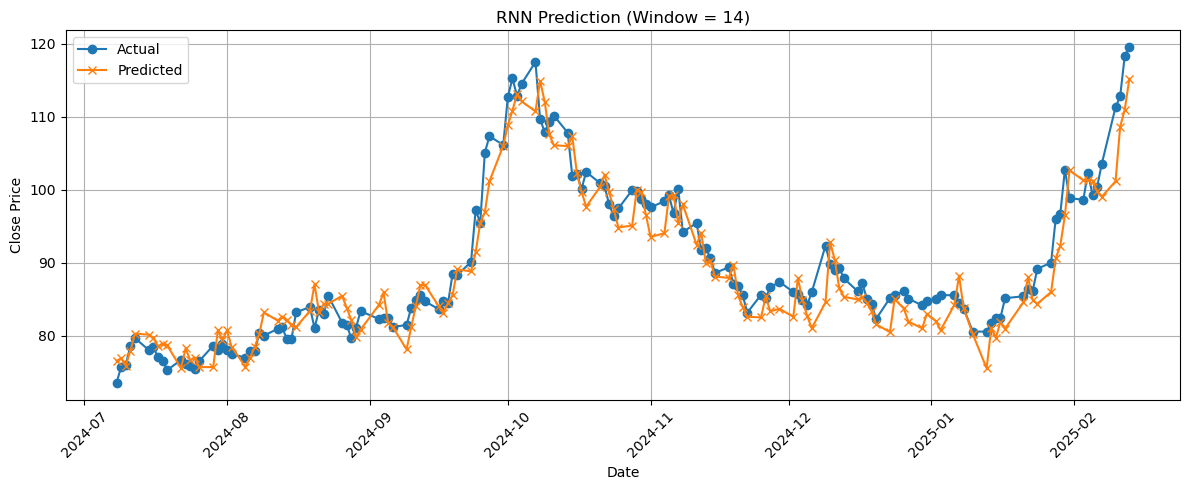

In [54]:
# calculate technical indicators for test set
df_test['RSI'] = calculate_rsi(df_test)
df_test['Stochastic_K'], df_test['Stochastic_D'] = stochastic_oscillator(df_test)
df_test['MACD'], df_test['MACD_Signal'], df_test['MACD_Hist'] = macd_features(df_test)
df_test['Bollinger_Upper'], df_test['Bollinger_Middle'], df_test['Bollinger_Lower'] = bollinger_bands(df_test)
df_test = df_test.dropna(subset=nan_col).reset_index(drop=True)
#build test features and true labels
X_test = df_test[selected_features]
y_test = df_test['Close']
Xs_test = pd.DataFrame(scaler_minmax.transform(X_test), columns=X_test.columns)

X_test_seq, y_test_seq = create_dataset(Xs_test.values, y_test.values, best_window_size)
X_train_seq, y_train_seq = create_dataset(Xs_scaled.values, y.values, best_window_size)

#rebuild RNN model using best hyperparameters from GridSearch
best_rnn_model = create_rnn(
    window_size=best_window_size,
    units=true_best_params['units'],
    dropout_rate=true_best_params['dropout_rate'],
    learning_rate=true_best_params['learning_rate'],
    n_features=Xs_scaled.shape[1]
)

best_rnn_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

#predict and evaluate on test set
y_pred_rnn = best_rnn_model.predict(X_test_seq)
mse_rnn = mean_squared_error(y_test_seq, y_pred_rnn)
r2_rnn = r2_score(y_test_seq, y_pred_rnn)
print(f"RNN MSE: {mse_rnn:.4f}, R²: {r2_rnn:.4f}")

date_test_seq = df_test['Date'].iloc[best_window_size:].reset_index(drop=True)
plt.figure(figsize=(12, 5))
plt.plot(date_test_seq, y_test_seq, label='Actual', marker='o')
plt.plot(date_test_seq, y_pred_rnn, label='Predicted', marker='x')
plt.title(f"RNN Prediction (Window = {best_window_size})")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


__XGBoost__

In [55]:
#add lag features
def add_lag_features(df, cols, lags):
    for col in cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df


In [56]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

#define which columns to lag and the lag steps
lag_cols = ['Close', 'Volume', 'RSI', 'MACD', 'Stochastic_K']
lags = [1, 2, 3]

df_train = add_lag_features(df_train, lag_cols, lags)
df_train = df_train.dropna().reset_index(drop=True)

feature_cols = [col for col in df_train.columns if '_lag' in col or col in selected_features]
X_train = df_train[feature_cols]
y_train = df_train['Close']

scaler_minmax = MinMaxScaler()
Xs_scaled = pd.DataFrame(scaler_minmax.fit_transform(X_train), columns=X_train.columns)

#parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

#create base XGBRegressor model
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

#grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(Xs_scaled, y_train)  
print("Best score:",grid_search.best_score_)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: -192.27224243178895
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


Test MSE: 5.9835
Test R²: 0.9471


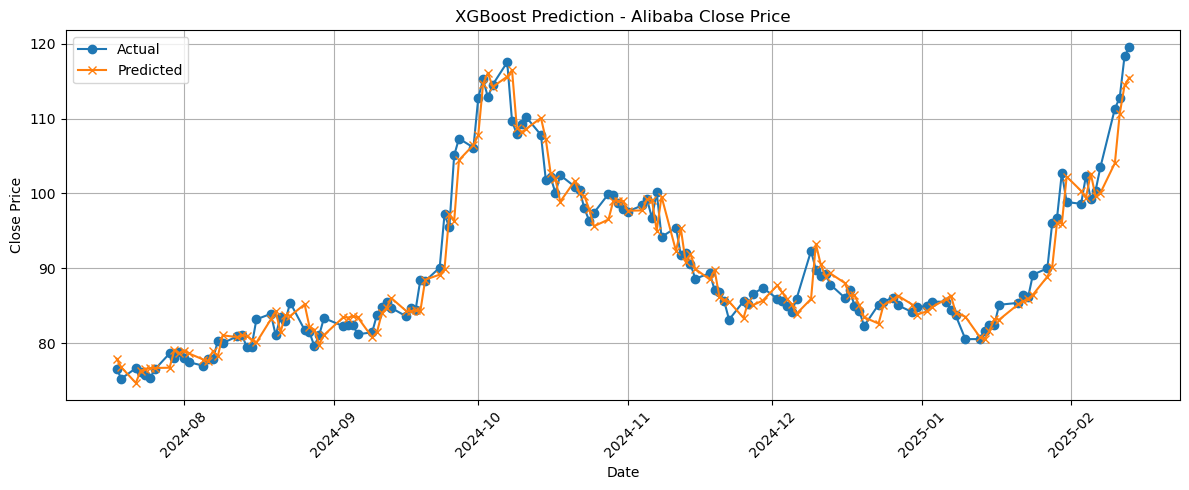

In [57]:
df_test['RSI'] = calculate_rsi(df_test)
df_test['Stochastic_K'], df_test['Stochastic_D'] = stochastic_oscillator(df_test)
df_test['MACD'], df_test['MACD_Signal'], df_test['MACD_Hist'] = macd_features(df_test) 
df_test['Bollinger_Upper'], df_test['Bollinger_Middle'], df_test['Bollinger_Lower'] = bollinger_bands(df_test)

df_test = df_test.dropna(subset=nan_col).reset_index(drop=True)
#add lag features to test set
df_test = add_lag_features(df_test, lag_cols, lags).dropna().reset_index(drop=True)
#build test features and true labels
X_test = df_test[feature_cols]
y_test = df_test['Close']
Xs_test_scaled = pd.DataFrame(scaler_minmax.transform(X_test), columns=X_test.columns)
#predict with best model
y_pred = grid_search.best_estimator_.predict(Xs_test_scaled)

best_model = grid_search.best_estimator_

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


plt.figure(figsize=(12,5))
plt.plot(df_test['Date'], y_test, label="Actual", marker='o')
plt.plot(df_test['Date'], y_pred, label="Predicted", marker='x')
plt.title("XGBoost Prediction - Alibaba Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
